# Constructing Time-Series and Survival Analysis Structures for Career Longevity Analysis

Now that we’ve built full career histories for 63,169 debut directors, the next step is to turn those histories into structures we can actually model. Creative careers unfold year by year, so this notebook builds two datasets:

1. A longitudinal frame tracking each director’s activity every year from their debut through 2023.
2. A cross-sectional snapshot that summarizes their first 11 post-debut years, including whether and when they made a second movie.

These two views give us the foundation for survival analysis: we can see when each director enters the industry, how long they stay active, and when they stop making movies. By structuring the data in this way, we’ll be able to estimate hazards, identify dropout patterns, and eventually model the factors that help some filmmakers keep working while others quietly fade out.

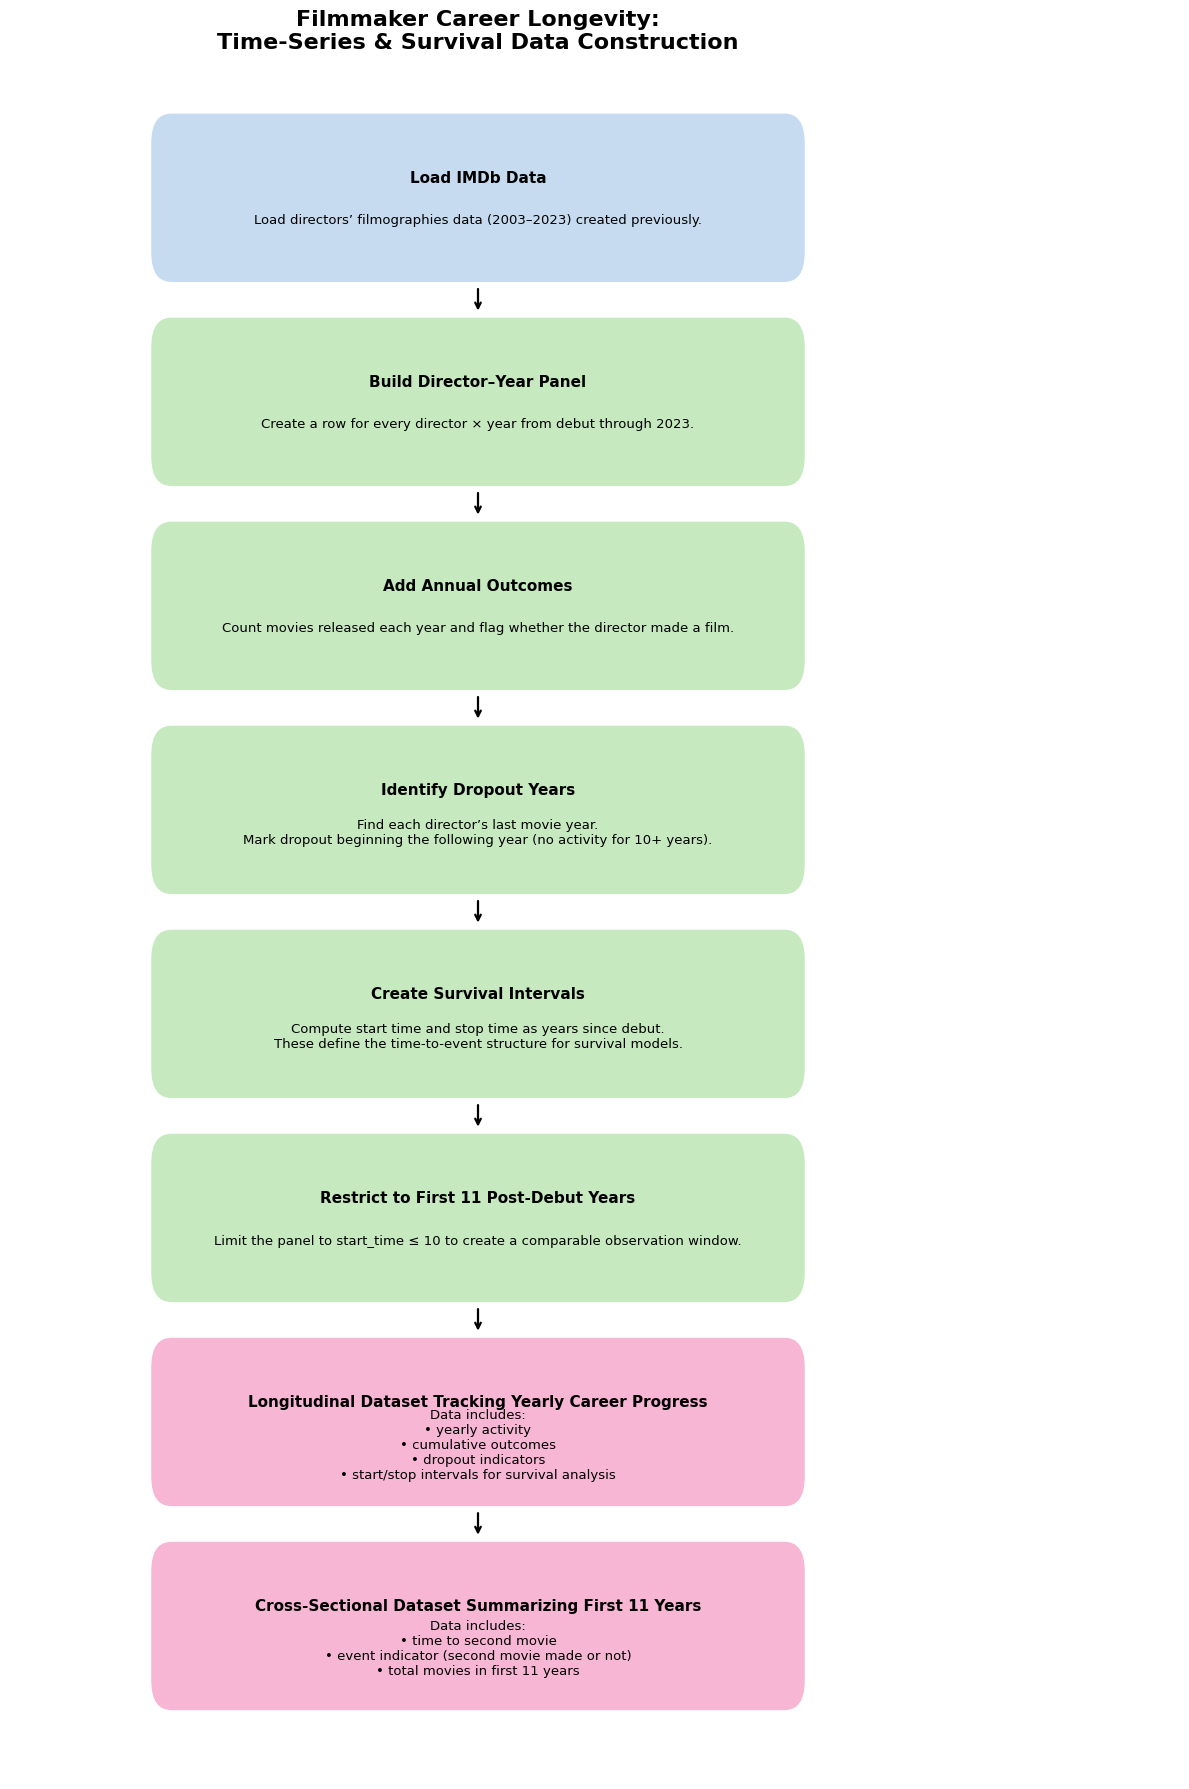

In [20]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# --- Figure (tall for clean spacing) ---
fig, ax = plt.subplots(figsize=(12, 18))
ax.axis("off")

# --- Colors by phase ---
colors = {
    "panel":       "#c6dbef",   # build longitudinal panel
    "engineering": "#c7e9c0",   # variable engineering / survival structure
    "output":      "#f7b6d3"    # final datasets
}

# --- Workflow steps for Notebook 02 ---
steps = [
    (
        "Load IMDb Data",
        "Load directors’ filmographies data (2003–2023) created previously.",
        "panel"
    ),
    (
        "Build Director–Year Panel",
        "Create a row for every director × year from debut through 2023.",
        "engineering"
    ),
    (
        "Add Annual Outcomes",
        "Count movies released each year and flag whether the director made a film.",
        "engineering"
    ),
    (
        "Identify Dropout Years",
        "Find each director’s last movie year.\n"
        "Mark dropout beginning the following year (no activity for 10+ years).",
        "engineering"
    ),
    (
        "Create Survival Intervals",
        "Compute start time and stop time as years since debut.\n"
        "These define the time-to-event structure for survival models.",
        "engineering"
    ),
    (
        "Restrict to First 11 Post-Debut Years",
        "Limit the panel to start_time ≤ 10 to create a comparable observation window.",
        "engineering"
    ),
    (
        "Longitudinal Dataset Tracking Yearly Career Progress",
        "Data includes:\n"
        "• yearly activity\n"
        "• cumulative outcomes\n"
        "• dropout indicators\n"
        "• start/stop intervals for survival analysis",
        "output"
    ),
    (
        "Cross-Sectional Dataset Summarizing First 11 Years",
        "Data includes:\n"
        "• time to second movie\n"
        "• event indicator (second movie made or not)\n"
        "• total movies in first 11 years",
        "output"
    ),
]

# --- Layout parameters (matching Notebook 01 style, narrow bars) ---
N = len(steps)
top_margin = 0.95
bottom_margin = 0.05

box_h = 0.04        # smaller box height
v_gap = 0.08        # vertical gap between boxes
step_pitch = box_h + v_gap

left = 0.15         # left x for boxes
box_w = 0.5         # width for readable text
text_pad_y = 0.002

# --- Draw boxes + arrows ---
for i, (title, text, category) in enumerate(steps):
    color = colors[category]

    # Box geometry
    y_top = top_margin - (i * step_pitch)
    y_box_bottom = y_top - box_h

    # Rounded rectangle
    box = FancyBboxPatch(
        (left, y_box_bottom), box_w, box_h,
        boxstyle="round,pad=0.03,rounding_size=0.018",
        facecolor=color, edgecolor="white", linewidth=1.2
    )
    ax.add_patch(box)

    # Bold title
    ax.text(
        left + box_w / 2,
        y_box_bottom + box_h / 2 + text_pad_y + 0.01,
        title,
        ha="center", va="center",
        fontsize=11, fontweight="bold"
    )
    # Description
    ax.text(
        left + box_w / 2,
        y_box_bottom + box_h / 2 + text_pad_y - 0.015,
        text,
        ha="center", va="center",
        fontsize=9.5, fontweight="regular"
    )

    # Arrow to next box
    if i < N - 1:
        next_y_top = top_margin - ((i + 1) * step_pitch)
        y_start = y_box_bottom - 0.4 * v_gap
        y_end = next_y_top + 0.4 * v_gap

        ax.annotate(
            "",
            xy=(left + box_w / 2, y_end),
            xytext=(left + box_w / 2, y_start),
            arrowprops=dict(arrowstyle="->", lw=1.6, color="black")
        )

# --- Title ---
plt.title(
    "Filmmaker Career Longevity:\nTime‑Series & Survival Data Construction",
    fontsize=16,
    fontweight="bold",
    pad=22,
    x=0.4   # nudge a bit left to align with boxes
)

plt.tight_layout()
plt.show()

# Import and Setup

In [ ]:
# Imports 
import pandas as pd                   # DataFrames
import os                             # File paths & OS ops
import seaborn as sns                 # Statistical plotting
import matplotlib.pyplot as plt       # General plotting
import numpy as np                    # Numeric operations
import math                           # Math functions
from lifelines import KaplanMeierFitter  # Survival analysis

# Set working directory 
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

# Build director-year longitudinal frame

We start by generating a row for every director-year combination from debut through 2023. This gives us a complete timeline for each director, which we can then populate with outcome and predictor variables.

In [ ]:
# Load directors’ filmographies (2003–2023)
# Built in Notebook 01_data_acquisition_sample_construction.ipynb
directors_full_filmography = pd.read_csv('directors_full_filmography.csv')

# Preview data structure
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.0,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004.0,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003.0,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008.0,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005.0,Drama,nm0000417,2005.0,5.3,950.0


In [ ]:
# Ensure years are integers
directors_full_filmography['startYear'] = directors_full_filmography['startYear'].astype(int)

#–– Construct director-year frame ––#
# Unique directors and full year range
directors = directors_full_filmography['nconst'].unique()
years = range(2003, 2024) 

# All director × year combos
directors_years = pd.DataFrame([(director, year) for director in directors for year in years], columns=['nconst', 'year'])

# Attach debut year to filter pre-debut
directors_years = directors_years.merge(directors_full_filmography[['nconst', 'firstYear']].drop_duplicates(), on='nconst', how='left')

# Keep only years ≥ debut and rename
directors_years = directors_years[directors_years['year'] >= directors_years['firstYear']].drop(columns=['firstYear'])
directors_years.rename(columns={'nconst': 'nconst_director'}, inplace=True)

# Identify each director’s debut year
debut_years = directors_years.groupby('nconst_director')['year'].min().reset_index()
debut_years.rename(columns={'year': 'debut_year'}, inplace=True)

# Merge debut_year back in
directors_years = pd.merge(directors_years, debut_years, on='nconst_director', how='left')

In [4]:
directors_years.head(25)

,nconst_director,year,debut_year
0,nm1131265,2004,2004
1,nm1131265,2005,2004
2,nm1131265,2006,2004
3,nm1131265,2007,2004
4,nm1131265,2008,2004
5,nm1131265,2009,2004
6,nm1131265,2010,2004
7,nm1131265,2011,2004
8,nm1131265,2012,2004
9,nm1131265,2013,2004


In [5]:
directors_years.to_csv("directors_years.csv", index=False)

# Creating outcome variables for time series data

We build a longitudinal/time series dataset that provides a year-by-year record for each director from debut through 2023, with information on whether they made a movie that year, how many movies they made, and whether they subsequently dropped out. Those who have not made a movie in the last 10 years are considered to have dropped out.

In [ ]:
# Preview filmography 
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005,Drama,nm0000417,2005.0,5.3,950.0


In [ ]:
# Count annual movie releases 
movies_released_per_year = directors_full_filmography.groupby(['nconst', 'startYear'])['tconst'].nunique().reset_index()

# Rename for merge
movies_released_per_year.rename(columns={'nconst': 'nconst_director', 'startYear': 'year', 'tconst': 'num_movies'}, inplace=True)

# Merge counts into director-year frame
directors_years_outcomes = directors_years.merge(movies_released_per_year, on=['nconst_director', 'year'], how='left')

# Fill missing → zero movies
directors_years_outcomes['num_movies'] = directors_years_outcomes['num_movies'].fillna(0)

# Flag years with any movie
directors_years_outcomes['made_movie'] = (directors_years_outcomes['num_movies'] > 0).astype(int)

# Zero out debut year activity
directors_years_outcomes.loc[directors_years_outcomes['year'] == directors_years_outcomes['debut_year'], ['num_movies', 'made_movie']] = 0

In [8]:
directors_years_outcomes.head(25)

,nconst_director,year,debut_year,num_movies,made_movie
0,nm1131265,2004,2004,0.0,0
1,nm1131265,2005,2004,0.0,0
2,nm1131265,2006,2004,0.0,0
3,nm1131265,2007,2004,0.0,0
4,nm1131265,2008,2004,0.0,0
5,nm1131265,2009,2004,0.0,0
6,nm1131265,2010,2004,0.0,0
7,nm1131265,2011,2004,0.0,0
8,nm1131265,2012,2004,0.0,0
9,nm1131265,2013,2004,1.0,1


In [ ]:
#–– Determine dropout years ––#
# Last movie per director
last_movie_year = directors_full_filmography.groupby('nconst')['startYear'].max().reset_index()

# Directors with no movie after 2013 considered dropped out
dropout_directors = last_movie_year[last_movie_year['startYear'] < 2014].copy()
dropout_directors['dropoutYear'] = dropout_directors['startYear'] + 1

# Others still active → no dropoutYear
active_directors = last_movie_year[last_movie_year['startYear'] >= 2014].copy()
active_directors['dropoutYear'] = pd.NA

# Combine and sort
all_directors_dropout = pd.concat([dropout_directors, active_directors], ignore_index=True).sort_values(by='nconst')

In [10]:
# Display the first few rows of the combined dataframe
all_directors_dropout.head()

,nconst,startYear,dropoutYear
43523,nm0000083,2022,<NA>
0,nm0000136,2009,2010
1,nm0000147,2010,2011
43524,nm0000154,2016,<NA>
2,nm0000155,2013,2014


In [ ]:
# Merge dropout info
directors_years_outcomes = pd.merge(directors_years_outcomes, all_directors_dropout[['nconst', 'dropoutYear']],
                                    how='left', left_on='nconst_director', right_on='nconst')
directors_years_outcomes.drop(columns='nconst', inplace=True)

# Initialize dropout flag
directors_years_outcomes['dropout'] = 0
# Mark all years ≥ dropoutYear as dropout
directors_years_outcomes['dropoutYear'] = pd.to_numeric(directors_years_outcomes['dropoutYear'], errors='coerce')  
directors_years_outcomes['dropout'] = ((directors_years_outcomes['year'] >= directors_years_outcomes['dropoutYear'].fillna(9999)).astype(int))

In [ ]:
directors_years_outcomes.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout
0,nm1131265,2004,2004,0.0,0,NaN,0
1,nm1131265,2005,2004,0.0,0,NaN,0
2,nm1131265,2006,2004,0.0,0,NaN,0
3,nm1131265,2007,2004,0.0,0,NaN,0
4,nm1131265,2008,2004,0.0,0,NaN,0
5,nm1131265,2009,2004,0.0,0,NaN,0
6,nm1131265,2010,2004,0.0,0,NaN,0
7,nm1131265,2011,2004,0.0,0,NaN,0
8,nm1131265,2012,2004,0.0,0,NaN,0
9,nm1131265,2013,2004,1.0,1,NaN,0


In [ ]:
#–– Prepare survival times ––#
# Relative times since debut
directors_years_outcomes['start_time'] = directors_years_outcomes['year'] - directors_years_outcomes['debut_year']
directors_years_outcomes['stop_time'] = directors_years_outcomes['start_time'] + 1

In [14]:
directors_years_outcomes.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5
5,nm1131265,2009,2004,0.0,0,NaN,0,5,6
6,nm1131265,2010,2004,0.0,0,NaN,0,6,7
7,nm1131265,2011,2004,0.0,0,NaN,0,7,8
8,nm1131265,2012,2004,0.0,0,NaN,0,8,9
9,nm1131265,2013,2004,1.0,1,NaN,0,9,10


In [15]:
directors_years_outcomes.to_csv("directors_years_outcomes.csv", index=False)

# Build cross-sectional data for each director

We build a dataset that summarizes each director’s first 11 post-debut years, with information on whether and when they made a second movie, and total number of movies made in that period. 

In [164]:
directors_years_outcomes.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5
5,nm1131265,2009,2004,0.0,0,NaN,0,5,6
6,nm1131265,2010,2004,0.0,0,NaN,0,6,7
7,nm1131265,2011,2004,0.0,0,NaN,0,7,8
8,nm1131265,2012,2004,0.0,0,NaN,0,8,9
9,nm1131265,2013,2004,1.0,1,NaN,0,9,10


In [ ]:
# Filter to first 11 years
filtered_data = directors_years_outcomes[directors_years_outcomes['start_time'] <= 10].copy()

# Cumulative film count
filtered_data['cumulative_movies'] = filtered_data.groupby('nconst_director')['num_movies'].cumsum()

# Time to second movie (cumulative ≥1 after debut)
second_movie_time = filtered_data[filtered_data['cumulative_movies'] >= 1].groupby('nconst_director')['start_time'].min()
second_movie_df = second_movie_time.reset_index()
second_movie_df.columns = ['nconst_director', 'time_to_second_movie']

# Cross-sectional summary
directors_cross_sectional = filtered_data[['nconst_director', 'debut_year']].drop_duplicates().merge(second_movie_df, on='nconst_director', how='left')
# Event indicator for second movie
directors_cross_sectional['event'] = (~directors_cross_sectional['time_to_second_movie'].isna()).astype(int)  # 1 if second movie made, 0 if not

# Censor times at 11 if no second movie
directors_cross_sectional['time_to_second_movie'] = directors_cross_sectional['time_to_second_movie'].fillna(11)

In [ ]:
# Total movies in first 11 years
total_movies = directors_years_outcomes[directors_years_outcomes['start_time'] < 11].groupby('nconst_director')['num_movies'].sum().reset_index()
total_movies.columns = ['nconst_director', 'total_movies']

# Merge and save cross-sectional data
directors_cross_sectional = directors_cross_sectional.merge(total_movies, on='nconst_director', how='left')

In [163]:
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.0,1,1.0
1,nm1130611,2004,11.0,0,0.0
2,nm0290651,2003,11.0,0,0.0
3,nm0404033,2003,5.0,1,1.0
4,nm0000417,2005,2.0,1,1.0


In [ ]:
directors_cross_sectional.to_csv("directors_cross_sectional.csv", index=False)

# Summary

This notebook transformed the raw filmographies from Notebook 01 into the structures needed for survival modeling. Specifically, we:

- Built a director-year longitudinal panel from debut through 2023
- Added annual outcomes (movies made, activity flags)
- Identified dropout years for each director
- Constructed start_time and stop_time intervals for survival models
- Filtered the data to the first 11 years post-debut
- Created a cross-sectional dataset summarizing:
  - time to second movie
  - event indicators
  - total output in the first 11 years

Together, these datasets form the foundation for survival analysis of filmmaker career longevity, which we will explore in subsequent notebooks.
